In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import simplejson as json

# Introduction

In this Notebook we will implement the mixed membership time dependent stochastic role model method, using two-step gradient descent method described in the paper _Name of paper_, we will also show its implementation as in the example of the paper. The notebook does not make any explicit reference to equations on the paper, and therefore can be read independently. The paper, however, sets the context in which the notebook makes sense.

## Definition of the model

The motivation of the model is to interpret (after a suitable discretisation) the expected number $ \mu_{s[i],s[j],h[t]}$ of interactions between a station $s[i]$ and a station $s[j]$ over time as the sum of all the possible time-dependent reasons $R^{r[\alpha],r[\beta]}_{h[t]}$ a person has to travel, weighed by how rellevant are this reasons in stations $s[i]$ and $s[j]$ (the relevance being denoted $C_{s[i],r[\alpha]}$). We can express this as:

**Definition of the station-pair movement strength as a function of the roles and coefficients**

\begin{equation}
    \mu_{s[i],s[j],h[t]} = \sum_{r[\alpha] r[\beta]} C_{s[i],r[\alpha]} R^{r[\alpha],r[\beta]}_{h[t]}C_{s[j],r[\beta]}
\end{equation}

or, in Python:

In [2]:
def mu(c,r):
    return np.einsum("ia,abt,jb->ijt",c,r,c)

It seems reasonable to assume that the actual number of travelers $ n_{s[i],s[j],h[t]}$ from station $s[i]$ to station $s[j]$ will  will be a Poisson random variable with parameter $ \mu_{s[i],s[j],h[t]}$, that is:

**Log Likelihood of the model** (As a function of the station-pair weights)
\begin{equation}
    L = \sum_{s[i],s[j],h[t]} n_{s[i],s[j],h[t]} \log \mu_{s[i],s[j],h[t]} - \mu_{s[i],s[j],h[t]}
\end{equation}

or, in Python:

In [3]:
def mu_likelihood(n, mu):
    return np.sum(n*np.log(mu)-mu)

in practice, most of the time we will actually be computing the likelihood as a function of the parameters $R^{r[\alpha],r[\beta]}_{h[t]}$ and $C_{s[i],r[\alpha]}$, that is:

In [4]:
def likelihood(c,r,n):
    return mu_likelihood(n,mu(c,r))

## Gradients

In order to perform gradient descent, we must compute the scores of the likelihood. It is easier to compute the derivatives with respect of $\mu$ and backpropagate afterwards.

**Score with respect of the station-pair weights**

\begin{equation}
    \frac{d L}{d \mu_{s[i],s[j],h[t]}} = \frac{n_{s[i],s[j],h[t]}}{  \mu_{s[i],s[j],h[t]}} -1
\end{equation}

or, in Python:

In [5]:
def mu_score(n,mu):
    return n/mu-1

Now we can start to propagate to the parameters of interest.

**Score with respect to $R^{r[\alpha],r[\beta]}_{h[t]}$:**

\begin{equation}
    \frac{d \mu_{s[i],s[j],h[t]}}{d R^{r[\alpha],r[\beta]}_{h[t]}} =  C_{s[i],r[\alpha]} C_{s[j],r[\beta]}
\end{equation}

\begin{equation}
    \frac{d L}{d R^{r[\alpha],r[\beta]}_{h[t]}} = 
        \sum_{s[i],s[j]} 
            \left(\frac{n_{s[i],s[j],h[t]}}{  \mu_{s[i],s[j],h[t]}} -1\right) 
            C_{s[i],r[\alpha]} C_{s[j],r[\beta]}
\end{equation}

note that the result is essentially a tensor multiplication including the score with respect of $\mu_{s[i],s[j],h[t]}$. Since we have already defined that score, we can use it, but we can save computation time by choosing whether we have it precomputed or not. In Python:

In [6]:
def r_score(c,r,n=None,back=None):
    if back is None and n is None:
        raise TypeError("Either n or the backprop should be specified")
    if back is None:
        back = mu_score(n,mu(c,r))
    return np.einsum("ijt,ia,jb->abt",back,c,c)

**Score with respect to $ C_{s[i],r[\gamma]}$:**

\begin{equation}\begin{aligned}
    \frac{d \mu_{s[i],s[j],h[t]}}{d C_{s[k],r[\gamma]}} =&
        \delta_{s[i],s[k]} 
        \sum_{ r[\beta]}
            R^{r[\gamma],r[\beta]}_{h[t]}C_{s[j],r[\beta]} 
        \\&+
        \delta_{s[j],s[k]}
        \sum_{r[\alpha]}
            C_{s[i],r[\alpha]}R^{r[\alpha],r[\gamma]}_{h[t]}
\end{aligned}\end{equation}

\begin{equation}\begin{aligned}
    \frac{d L}{d C_{s[k],r[\gamma]}} =&
        \sum_{s[j],r[\beta]} 
        \left(\frac{n_{s[k],s[j],h[t]}}{  \mu_{s[k],s[j],h[t]}} -1\right) 
                R^{r[\gamma],r[\beta]}_{h[t]}C_{s[j],r[\beta]} 
            \\&+
        \sum_{s[i],r[\alpha]} 
        \left(\frac{n_{s[i],s[k],h[t]}}{  \mu_{s[i],s[k],h[t]}} -1\right) 
                R^{r[\alpha],r[\gamma]}_{h[t]}C_{s[i],r[\alpha]}
\end{aligned}\end{equation}

the same considerations we described for the $R^{r[\alpha],r[\beta]}_{h[t]}$ case apply here. In Python:

In [7]:
def c_score(c,r,n=None,back=None):
    if back is None and n is None:
        raise TypeError("Either n or the backprop should be specified")
    if back is None:
        back = mu_score(n,mu(c,r))
    return np.einsum("kjt,gbt,jb->kg",back,r,c) + \
           np.einsum("ikt,agt,ia->kg",back,r,c)

# Optimization: 

## Log-Gradient descent algorithm

We use the log-gradient descent algorithm to overcome the numerical instabilities near $\mu_{s[i]s[j]}=0$. The idea is the following: We are given a function $f(x)$, $x\in{R^+}^{n}$ (positive $n$-tuples) which is unstable when any of the coefficients is $0$. Then we define $g = f \circ \exp$ a new function of a variable $y \in R^n$. We then perform gradient descent to $y$ to optimize, and then compute $x = \exp y$. This is done as:

$$
y_{n+1} = y_n + \alpha g'(y_n) = y_n + \alpha \nabla f(\exp(y_n)) \exp(y_n)
$$

(where all the operations, products, sums, exponentials.. are performed componentwise) now, using the fact that $x_n = \exp y_n$ we can translate this algorithm back to the $x_n$, as in:

$$
x_{n+1} = x_n \cdot \exp(\alpha x_n \nabla f(x_n))
$$

note that the new algorithm cannot create negative numbers! The algorithm, however, can become slow for small $x$. An option to overcome that is to remove the $x_n$ factor on the exponential, which prevents slow convergence near $0$, while still keeping the stability properties. More generally, this gives rise to a whole family of algorithms, inspired by gradient descent with change of variables, of the form $x_{n+1} = x_n h(\nabla x_n)$, where $h$ is a positive function with $f(0) = 1$. We will call this function the _exp_ function, but it may not be the exponential itself.

## Doubly adaptive gradient descent

Since we do not know a priori which is the good constant to perform gradient descent with, we will choose it addapteively. This, however, leads to a problem. We have two very diferent sets of coordinates, the $C_{s[k],r[\gamma]}$ and the $ R^{r[\gamma],r[\beta]}_{h[t]}$. We will perform gradient descent to each of the variables sepparately, one at a time, and choose different gradient descent constants for each of them. The gradient descent constants are updated at each step by comparing two different possible values for them.

The algorithm above, in its simplest implementation, can be written as:

In [8]:
def gradient_descent(n, #N, the real amount of trips
                   r0,c0, #The initial guesses
                   wr=1E-10, wc=1E-10, #Initial weights
                   N_ITERS=2500, 
                   exp = np.exp): #the "exponential" function
    #To keep track of whether we improve or not, 
    #we need to keep the initial likelihood
    old_likelihood=likelihood(c0,r0,n);
                     
    for i in range(N_ITERS):
        #Perform addaptive gradient descent to  R
        #=========================================
        rs = r_score(c0,r0,n) 
                 
        #Try two different weights, one smaller (wr*0.8) one bigger (wr*1.2)
        r1 = r0*exp(0.8*wr*rs);    r2 = r0*exp(1.2*wr*rs)
        l1 = likelihood(c0,r1,n);   l2 = likelihood(c0,r2,n)

        #choose (and keep) the best weight
        if l1>l2: r0=r1;  wr*=0.8;  l=l1;
        else:     r0=r2;  wr*=1.2;  l=l2;
        
        #Perform addaptive gradient descent to  C
        #=========================================
        #Copy of the code above
        cs = c_score(c0,r0,n)
                 
        c1 = c0*exp(down*wc*cs);          c2 = c0*exp(up*wc*cs)
        l1 = likelihood(c1,r0,n);     l2 = likelihood(c2,r0,n)
 
        if l1>l2:  c0=c1;  wc*=down;  l=l1;
        else:      c0=c2;  wc*=up;  l=l2;
                     
    return r0,c0

While the code above expresses the idea properly and shortly, it misses some useful components (such as logging, a progress bar...) Therefore we will use the prepared library code that essentially does the same to show the results. The main differences are:

* There is a safeguard preventing the weights from being negative (or less than $10^{-20}$). 
* There is logging
* The initial values for $C$ and $R$ are automatically generated from lognormal distributions with the right mean if no value is supplied.
* The values of $R$ and $C$ are normalised to take into account the degeneracy of solutions given by the simmetry:


$$(C_{s[k],r[\gamma]},R^{r[\alpha],r[\beta]}_{h[t]}C_{s[j],r[\beta]} ) \mapsto \lambda_{r[\gamma]} C_{s[k],r[\gamma]}, \lambda^{-1}_{r[\alpha]}  \lambda^{-1}_{r[\beta]} R^{r[\gamma],r[\beta]}_{h[t]} )$$

In [9]:
#the actual implementation of gradient desce t in the paper
#the one shown above is a version of the one in the library
#with multiple lines removed
from lib.gradient_mixed import gradient_descent

#This makes the role matrix plots from the paper
from lib.Matrix_plot import Matrix_plot 

# Testing the code:

## Testing in Bike Sharing data

Now that the code is ready, we can test it on the data from the bike network

In [10]:
city = 'LA'

In [11]:
with open('Tripbins/%s.json'%city) as f:
    trips = np.array(json.load(f))
trips = trips.transpose(1,2,0) #move the time to the end as expected by the gradient descend function

In [12]:
x = \
gradient_descent(trips, exp = lambda x: (1+x**2)**.5+x,
                 N=501,nroles=3,
                 verbose_time = 100, progressBar=True)

FloatProgress(value=0.0, max=501.0)

N: 	 C_RelChange 	 R_RelChange 	 log_like 	 d_log_like 	 time(s)
0	 4.415e-01	 4.702e-01	 -3.187e+06	 7.877e+06	 0.13
100	 2.100e-02	 9.483e-03	 -1.813e+04	 -7.189e+00	 9.95
200	 9.195e-03	 6.201e-03	 -1.790e+04	 4.492e-01	 19.56
300	 2.693e-04	 5.492e-04	 -1.790e+04	 8.946e-04	 29.19
400	 9.719e-04	 2.825e-03	 -1.790e+04	 6.488e-03	 38.78
500	 4.653e-04	 9.226e-04	 -1.790e+04	 1.138e-03	 48.04


<Figure size 432x288 with 0 Axes>

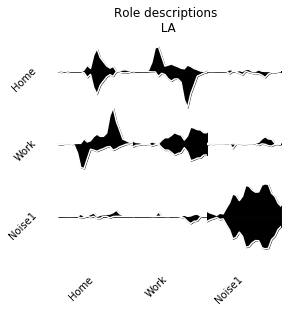

<Figure size 432x288 with 0 Axes>

In [13]:
r,c,_,_=x
(fig,ax)=Matrix_plot(r, ["Home","Work", "Noise1", "Noise2"] );
fig.set_size_inches(4,4)
fig.suptitle('Role descriptions\n {}'.format(city))
plt.figure()

## Testing in Artifficially generated data

### Generating data

We can also try some artifficially generated examples to see that the code works. We will start by generating data that is similar to the one in the datasets (moderately sparse, concentrated in the middle of the day..). We will use a random product of sines and cosines, of time for each compoent, for no particular reason.

In [14]:
t = np.linspace(0,1,24)
z = np.zeros((3,3,24))
for i in range(3):
    for j in range(3):
        z[i,j] = np.sin(8*(i+1)*t+10*np.random.normal())*\
                 np.sin(1*(j+1)*t+10*np.random.normal())*\
                 np.cos(2*(i-j)*t+10*np.random.normal())*np.random.normal()\
                 +1E-1
z = z*(z>0)
z*=(0.2-np.cos(6.28*t))
z = z*(z>0)
z/=np.mean(z)

We can plot the randomly generated data:

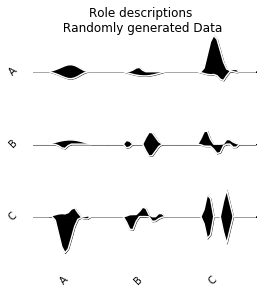

In [15]:
(fig,ax)=Matrix_plot(z,['A','B','C'])
fig.set_size_inches(4,4)
fig.suptitle('Role descriptions\n {}'.format('Randomly generated Data'));

We only have to generate the weight constants for the stations (we will generate them from exponential variables, but other tests could be made), and generate a poisson random variable for the stations from here.

In [16]:
n_stations = 40
mean_trips_per_pair_per_hour = 1
st = np.random.exponential(size = (n_stations,3))

expected_trips = np.einsum(('ij,jkt,lk->ilt'), st, z, st)
expected_trips*= mean_trips_per_pair_per_hour/np.mean(expected_trips)
trips = np.random.poisson(expected_trips)

### Testing on the data

Having a tensor of trips (the $ n_{s[i],s[j],h[t]}$ tensor), we can run the algorithm we just designed:

In [18]:
x = \
gradient_descent(trips+1E-4, exp = lambda x: (1+x**2)**.5+x,
                N=1301,nroles=3,
                verbose_time = 100, progressBar=True)

FloatProgress(value=0.0, max=1301.0)

N: 	 C_RelChange 	 R_RelChange 	 log_like 	 d_log_like 	 time(s)
0	 2.975e-01	 7.536e-02	 -8.034e+05	 6.214e+05	 0.02
100	 3.711e-03	 1.090e-02	 7.828e+03	 1.038e+00	 1.77
200	 1.014e-03	 2.625e-03	 7.856e+03	 4.308e-02	 3.47
300	 1.399e-04	 5.768e-04	 7.857e+03	 1.088e-02	 5.19
400	 1.588e-04	 4.358e-04	 7.858e+03	 5.094e-03	 6.85
500	 2.205e-04	 2.981e-04	 7.859e+03	 4.429e-03	 8.55
600	 1.342e-04	 3.706e-04	 7.859e+03	 1.770e-03	 10.21
700	 4.290e-05	 2.130e-04	 7.859e+03	 3.897e-04	 11.88
800	 9.060e-05	 1.150e-04	 7.859e+03	 2.489e-05	 13.55
900	 6.821e-04	 1.437e-04	 7.859e+03	 -9.713e-03	 15.21
1000	 1.066e-05	 3.698e-05	 7.859e+03	 4.698e-05	 16.88
1100	 1.776e-05	 3.239e-05	 7.859e+03	 7.497e-06	 18.57
1200	 7.521e-05	 2.917e-04	 7.859e+03	 -3.551e-04	 20.25
1300	 1.658e-05	 2.594e-04	 7.859e+03	 9.234e-04	 21.92


And if we plot the results (note that the will most likely be shuffled):

Text(0.5,0.98,'Role descriptions\n Recovery of the generated data')

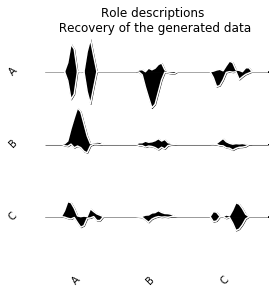

In [19]:
r,c,_,_=x
(fig,ax)=Matrix_plot(r, ["A","B", "C"] );
fig.set_size_inches(4,4)
fig.suptitle('Role descriptions\n {}'.format('Recovery of the generated data'))